# Seattle Weather Prediction
I have two objectives with this notebook. First, I want to use it to illustrate some of the points that I made in the related article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('seattle-weather.csv')
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date             datetime64[ns]
precipitation           float64
temp_max                float64
temp_min                float64
wind                    float64
weather                  object
dtype: object

In [3]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [4]:
df['temp_range'] = df['temp_max'] - df['temp_min']
le = LabelEncoder()
df['weather_label']=le.fit_transform(df['weather'])

base_features=['precipitation', 'temp_max', 'temp_min', 'wind', 'temp_range']
features = base_features.copy()
# for feature in base_features:
#     df[feature+'2'] = df[feature] ** 2
#     features.append(feature+'2')
#     df['sqrt_'+feature] = df[feature] ** 0.5
#     features.append('sqrt_'+feature)
#     df['log_'+feature] = np.log(df[feature] + 1)
#     features.append('log_'+feature)
    

# get season
season_map = {1:'Winter',
     2:'Winter',
     3:'Spring',
     4:'Spring',
     5:'Spring',
     6:'Summer',
     7:'Summer',
     8:'Summer',
     9:'Autumn',
     10:'Autumn',
     11:'Autumn',
     12:'Winter'
    }
df['season'] = df['date'].dt.month.map(season_map)
# pandas get_dummies
df = pd.get_dummies(df,columns=['season'])
features = features + ['season_Spring','season_Summer','season_Autumn','season_Winter']

print(features)


['precipitation', 'temp_max', 'temp_min', 'wind', 'temp_range', 'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter']


In [5]:
X=df[features]
y=df['weather_label']
Xtrain, Xtest, y_train, y_test = train_test_split(X, y, shuffle = True)

# Scale data
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler()
X_train = s.fit_transform(Xtrain)
X_test = s.transform(Xtest)

In [6]:
df[df['weather'] == 'drizzle'].describe()

,precipitation,temp_max,temp_min,wind,temp_range,weather_label,season_Autumn,season_Spring,season_Summer,season_Winter
count,53.0,53.000000,53.000000,53.000000,53.000000,53.0,53.000000,53.000000,53.000000,53.000000
mean,0.0,15.926415,7.111321,2.367925,8.815094,0.0,0.226415,0.132075,0.339623,0.301887
std,0.0,8.812036,6.182191,0.911418,3.711904,0.0,0.422516,0.341813,0.478113,0.463470
min,0.0,1.100000,-3.900000,0.600000,1.700000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,8.300000,1.700000,1.800000,6.600000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.0,16.100000,8.300000,2.100000,8.300000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.0,23.900000,12.800000,2.700000,12.200000,0.0,0.000000,0.000000,1.000000,1.000000
max,0.0,31.700000,16.100000,4.700000,15.600000,0.0,1.000000,1.000000,1.000000,1.000000


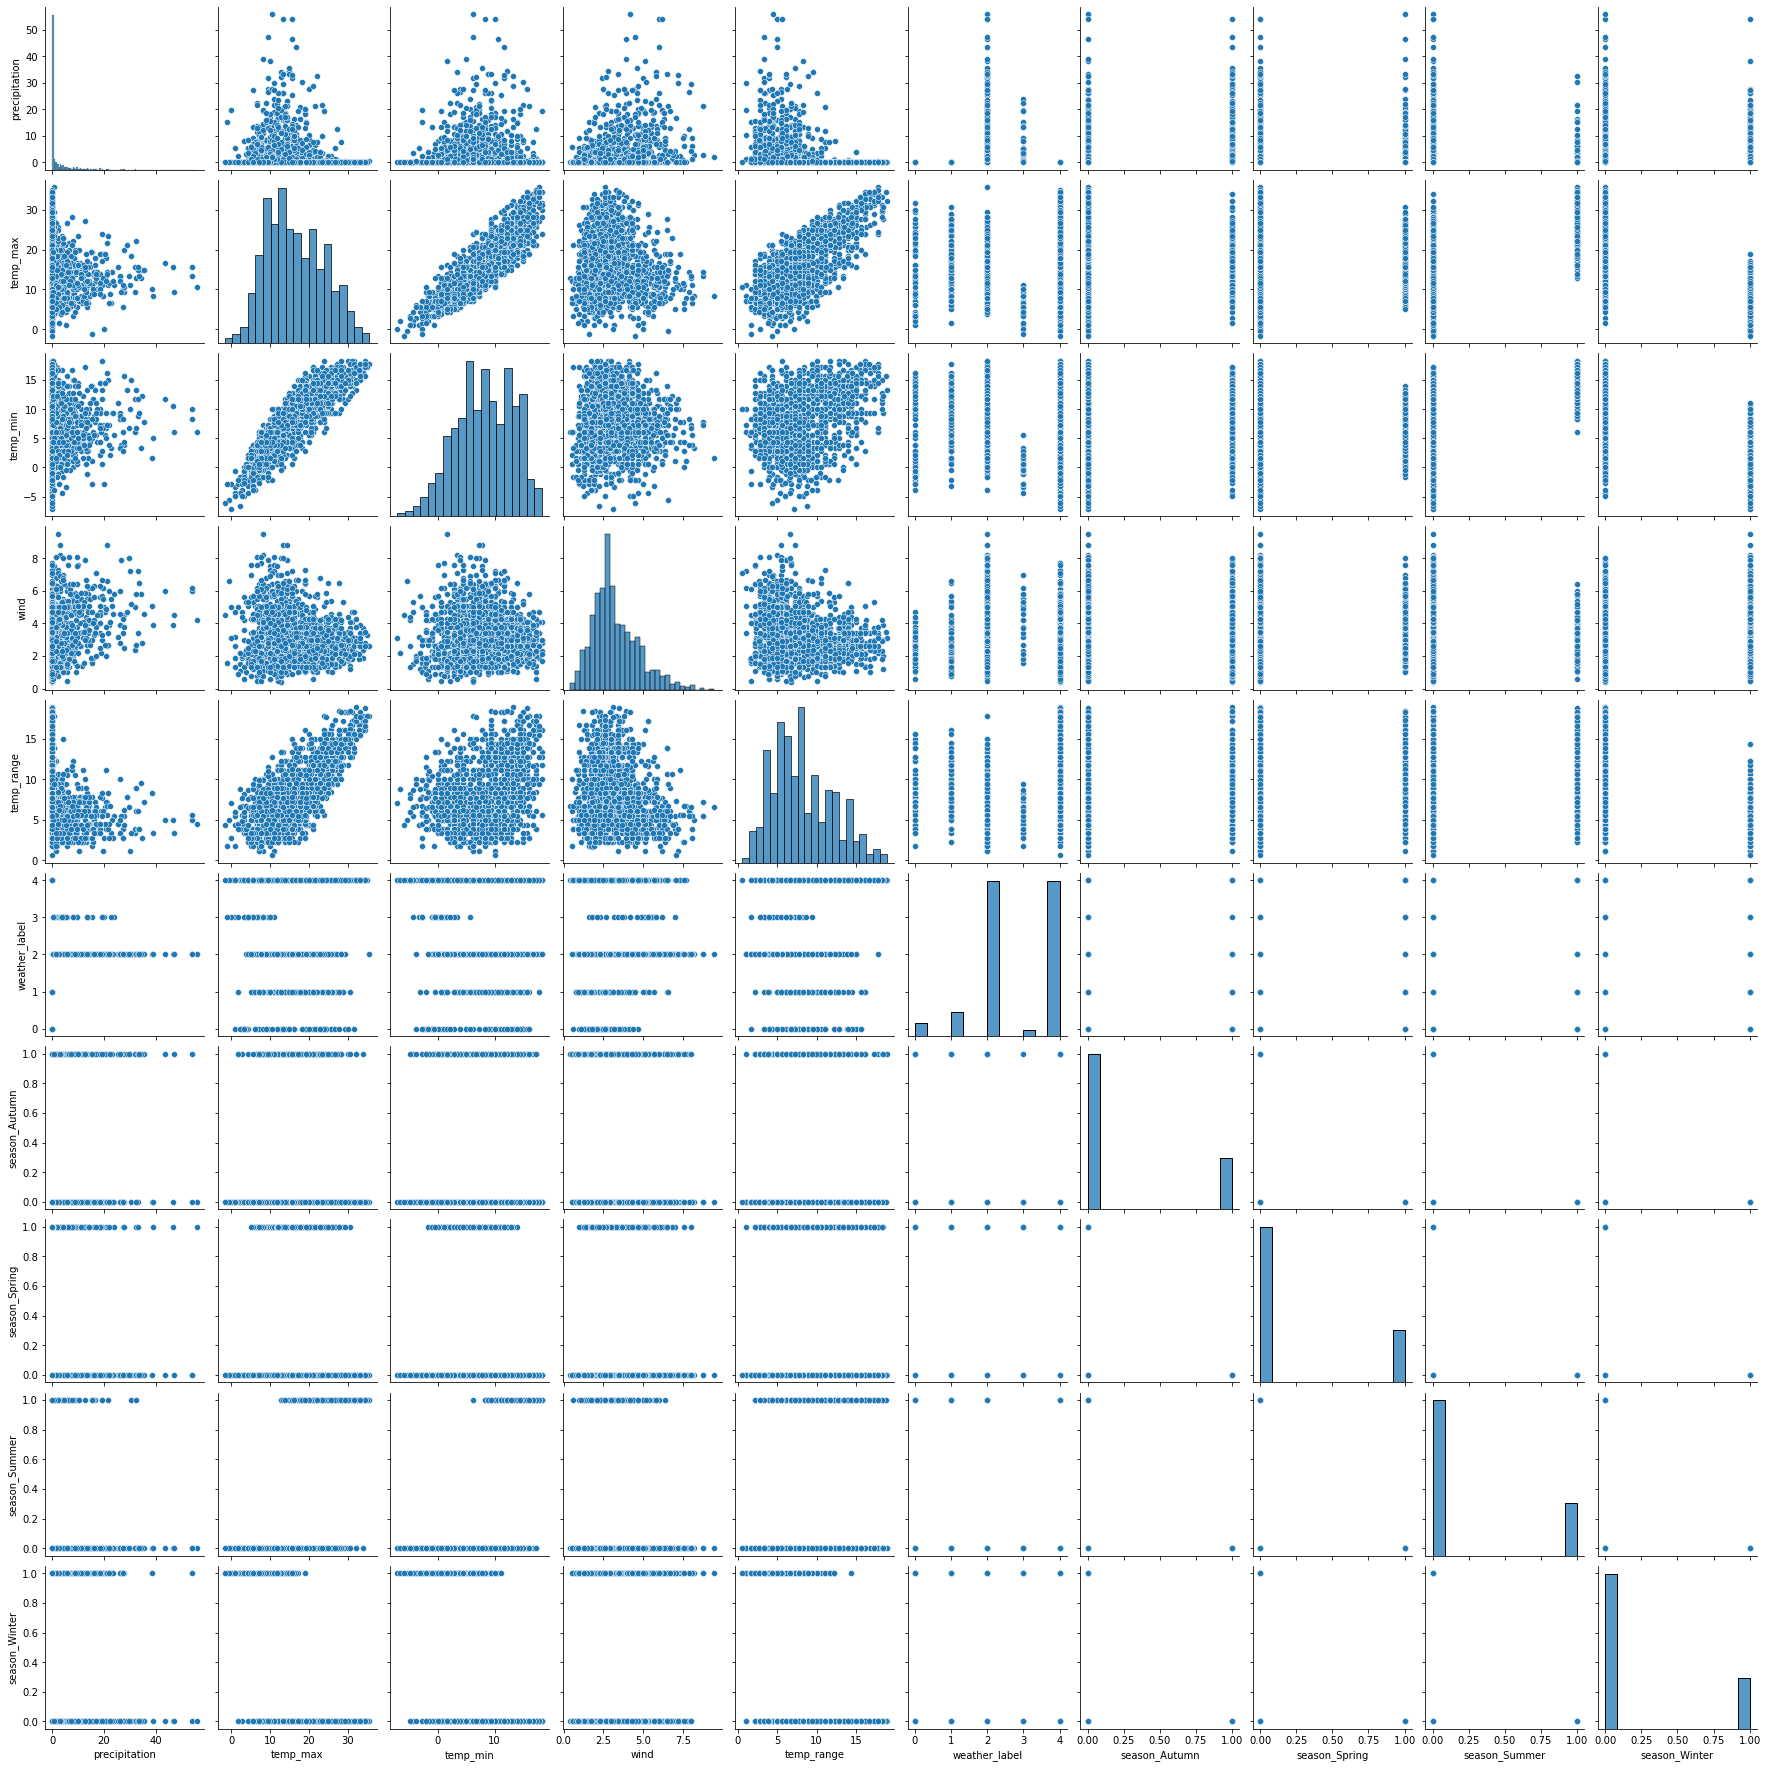

In [7]:
sns.pairplot(df)

logistic regression with lasso regularization


In [17]:
class_weight = {}
n_samples = len(y_train)
n_classes = 5
for class_number, count in enumerate(np.bincount(y_train)):
    print(f'{le.classes_[class_number]}: {count}')#class_number, count)
    class_weight[class_number] = n_samples / (n_classes * count)
print(class_weight)

drizzle: 38
fog: 78
rain: 474
snow: 15
sun: 490
{0: 5.7631578947368425, 1: 2.8076923076923075, 2: 0.4620253164556962, 3: 14.6, 4: 0.44693877551020406}


In [22]:
Cs = np.logspace(-2, 5, 8)
coef_dfs = [pd.DataFrame(columns=features,index=Cs)] * 5

for C in Cs:
    clf = LogisticRegression(solver = 'saga',penalty='l1', max_iter = 10000, C = C, class_weight=class_weight)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    for i,coef_df in enumerate(coef_dfs):
        coef_df.loc[C] = clf.coef_[i]
    print('C:',C)
    print('Score:',clf.score(X_test,y_test))
    print('Class predictions',np.unique(y_pred, return_counts=True))
    print('')
    

C: 0.01
Score: 0.06284153005464481
Class predictions (array([1]), array([366], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 0.1
Score: 0.4207650273224044
Class predictions (array([0, 1, 2, 3, 4]), array([ 71,  45,  86,  48, 116], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 1.0
Score: 0.6584699453551912
Class predictions (array([0, 1, 2, 3, 4]), array([  6,  50, 121,  42, 147], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 10.0
Score: 0.5901639344262295
Class predictions (array([0, 1, 2, 3, 4]), array([ 53,  62, 184,   8,  59], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 100.0
Score: 0.546448087431694
Class predictions (array([0, 1, 2, 3, 4]), array([142,  16, 141,  23,  44], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 1000.0
Score: 0.5956284153005464
Class predictions (array([0, 1, 2, 3, 4]), array([ 90,  35, 123,  40,  78], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 10000.0
Score: 0.5710382513661202
Class predictions (array([0, 1, 2, 3, 4]), array([115,  39, 146,  25,  41], dtype=int64))

C: 100000.0
Score: 0.6857923497267759
Class predictions (array([0, 1, 2, 3, 4]), array([ 30,  37, 129,  37, 133], dtype=int64))



C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


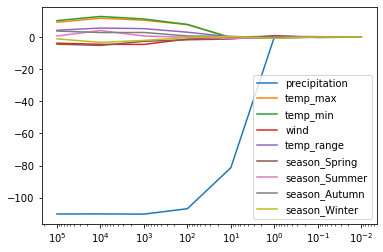

In [11]:
coef_dfs[1].plot(logx=True)
plt.gca().invert_xaxis()

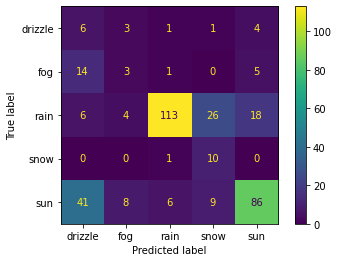

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot()